# **Final Template - AI Course**
Based on:
- [Ahmadreza Attarpour](https://github.com/AAttarpour) for MBP1413H.
- [MONAI tutorial](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

For Kaggle Competition:
- [2018 Data Science Bowl](https://www.kaggle.com/competitions/data-science-bowl-2018/leaderboard) for Nucleus segmentation


FIJI:
- Color Images are preprocess in FIJI - converted to Grayscale 8bit Binary
- Mask images are joined into one file via Maximum Intensity projection (so to have all nucleus masks in one single file)
- Mask images for Stage-1 test were provided as RLE encoded. Last cell in this file illustrates the conversion method to images

# **Section 1: Setup environment**




In [36]:
import os
from os.path import dirname, basename
import glob
import numpy as np
import skimage
from skimage import io
import cv2
import seaborn as sns
#for CUDA Debugging
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #used only for CUDA debugging

#IMPORT
import monai
import matplotlib
%matplotlib inline

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ForegroundMask,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandZoomd,
    RandAffined,
    RandCoarseDropoutd,
    RandGaussianSmoothd,
    RandHistogramShiftd,
    RandGaussianNoised,
    RandShiftIntensityd,
    RandAdjustContrastd,
    RandAxisFlipd,
    SaveImage
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import einops #for UNETR

print_config()

MONAI version: 1.3.0
Numpy version: 1.21.5
Pytorch version: 2.0.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.1
scikit-image version: 0.19.2
scipy version: 1.7.3
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.3
TorchVision version: 0.15.2
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.4.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
  

In [37]:
#HyperParameter Combinations
HyperCombo = 1

##################
#### UNET ####### 
#################
model_name = str(HyperCombo)+"_UNET_model.pth"
directory = "Results/" #for saving results

##################
#### UNETR ######
#################
#directory = "Results_UNETR/"
#model_name = str(HyperCombo)+"_UNETR_model.pth"

#Test Directory
parent_dir = "/home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/"
Train="Train_670/stage1_train_MaskMIP_Raw8bit/"
Test="Test_65/stage1_test/"
root_dir = os.path.join(parent_dir, directory)
if not os.path.exists(root_dir):
        os.mkdir(root_dir)
data_dir = os.path.join(parent_dir, Train)
Test_directory= os.path.join(parent_dir, Test)

print(model_name)
Hyper_folder = root_dir+"Res_"+str(HyperCombo) #HyperParameter Combination testing folder
print(Hyper_folder)
if not os.path.exists(Hyper_folder):
        os.mkdir(Hyper_folder)

1_UNETR_model.pth
/home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results_UNETR/Res_1


In [3]:
#IF NEEDED: zip
#ZipFile='/stage1_train_MaskMIP_Raw8bit.zip'
#print(ZipFile)
#!unzip /stage1_train_MaskMIP_Raw8bit.zip -d /stage1/

In [38]:
#HYPERPARAMETERS

#winners used Random Crops: 256x256, Batch Size: 16, learning rate 1e-4 

# SPLIT RATIO HYPERPARAMETER
#Percentage of data to use for training (perc= training, remaining for validation)
perc=80
#perc=70
#perc=60

#MONTE CARLO DROPOUT: add drop out also at test evaluation
dropout=0.1
#dropout=0.2
#dropout=0.3

learning=1e-2
#learning=1e-3
#learning=1e-4
#learning=1e-5

CropSpatialSize =128 #enough for small 256*256 and 500*500 images when divided into x-NumSamples different crops

#Keep it due to image size being randomly cropped x-NumSamples times considering a size of CropSpatialSize
NumSamples=4

#How many images to fully process/augment before batch normalization
batchsize=2
#batchsize=3
#batchsize=4

MaxEpochs = 10 # - HYPERPARAMETER

ValInterval = 2 #i.e. 2 epoch training every 1 of validation - HYPERPARAMETER
#ValInterval = 4

#Loss Function and Evaluation Metrics
#Keep DiceLoss

In [39]:
train_images = sorted(glob.glob(os.path.join(data_dir, "*/RAW_images_8bit", "images.png")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "*/MIP", "MIP_mask.png")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

In [40]:
#print how many train_images and train_labels are available
n_image=len(train_images)
n_label=len(train_labels)
perc_train=int(perc/100*n_image) #Compute percentage for Training (rest for Validation)

print("N Images available images: " + str(n_image))
print("N Label available images: " + str(n_label))
print("Percentage for Training/Validatio Ratio: "+str(perc)+"%")
print("N Training Images: " + str(perc_train))


#Time to Choose Train and Validation Split Ratios! #HYPERPARAMETER
train_files, val_files = data_dicts[-perc_train:], data_dicts[:-perc_train]

N Images available images: 670
N Label available images: 670
Percentage for Training/Validatio Ratio: 80%
N Training Images: 536


In [10]:
#print(f"training data: {train_files}")
#print(f"validating data: {val_files}")

## Set deterministic training for reproducibility

In [41]:
set_determinism(seed=0)

# **Section 2:  Set up data loader and augmentation transforms**


## MONAI [transforms](https://docs.monai.io/en/latest/transforms.html)


In [42]:
#TRANSFORMS set for 2D images (png)

# Define training transforms
train_transforms = Compose(
    [
        #it's a LIST for all the Data Augmentation STEPS

        # Load image and label data
        LoadImaged(keys=["image", "label"]),  #LoadImaged has d at the end as it is the dictionary version of the Image Loader
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]), #since we are using Pytorch, it  assumes that the tensor size is Batch*Channel*Height*Width*Depth (Batch will be added as we progress in the model)

        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=255.0,
            clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
#CHECK FOR COMPATIBILITY
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        # NOT NEEDED since no available information on actual voxel size (each voxel has dimension 1 despite different resolutions used)
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5), mode=("bilinear", "nearest")),

        #Zoom in on images
        RandZoomd(
            keys=["image", "label"],
            prob=0.1,
            min_zoom=1.3, max_zoom=1.8,
            mode=['area', 'nearest'],
        ),
        # Randomly crop regions with positive and negative labels to create training samples
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(CropSpatialSize,CropSpatialSize), #HYPERPARAMETER - this is the actual input size to the model -> used in this case for GPU memory usage and reduce the image size
            pos=1, #probability of taking a positive label in ratio compared to neg in the mask. Important that the pos label is at the center of the random crop so that along the UNET the convolutions will always be centered around the positive label
            neg=1,
            #HYPERPAMETER num_samples and batchsize
            num_samples=NumSamples, #in the model each image is cropped into num_samples cropped_images, and each of this will be fed to the network.
            #The Batch Normalization (with images, bias and weights held in memory) will be done every x cropped_images for a total equal to x = num_samples * batch_size
            # i.e. if x= 8= 4*2 then the batch normalization will be done every 2 full images being cropped by RandCropByPosNegLabeld 4 times
            image_key="image",
            image_threshold=0,
            # This Transform does not have any prob parameter as it is applied to each image
        ),
        #Random 2D Affine Transform
        RandAffined(
            prob=0.1,
            keys=['image', 'label'],
            mode=['bilinear','nearest'],
            rotate_range=(0, 6), #0 - 180 degrees
        ),
        #Random Axis Flip
        RandAxisFlipd(
        keys=['image', 'label'],
        prob=0.1, #axis randomly chosen
        ),
        #Random Intensity shift (i.e. initial pixel with value 11 is shifted by 10 resulting in 21)
        RandShiftIntensityd(
            keys=['image'],
            prob=0.1,
            offsets=(10,100),
        ),
        #Random Adjust Contrast with Gamma
        RandAdjustContrastd(
            keys=['image'],
            prob=0.1,
            gamma=(1.5,2),
        ),
        #Random Histogram Shift (number of control points is used for the nonlinear mapping of the histogram being shifted)
        RandHistogramShiftd(
            keys=['image'],
            prob=0.1,
            num_control_points=(3,10),
        ),
        #Random Gaussian Noise
        RandGaussianNoised(
            keys=['image'],
            prob=0.1,
            mean=0.0,
            std=10,
        ),
        #Random Gaussian Smoothing
        RandGaussianSmoothd(
            keys=['image'],
            sigma_x=(0.25, 1.5),
            sigma_y=(0.25, 1.5),
            prob=0.1,
        ),
        #Random Coarse dropout of voxels with value attributed by fill_value, holes and max_holes indicate the min and max of how many drops to occur with certain min and max spatial sizes in pixels
        RandCoarseDropoutd(
            keys=['image', 'label'],
            holes=5, max_holes=20,
            spatial_size=2, max_spatial_size=8,
            dropout_holes=True,
            fill_value=0,
            prob=0.1,
        ),

    ]
)

# Define validation transforms
val_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]),

        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=255.0,
            clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
#CHECK FOR COMPATIBILITY
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        # NOT NEEDED since no available information on actual voxel size (each voxel has dimension 1 despite different resolutions used)
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5), mode=("bilinear", "nearest")),

    ]
)

## Check transforms in DataLoader and plot one sample image

Checking Images/Labels as-is (Validation Dataset)
image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])
<class 'monai.data.meta_tensor.MetaTensor'>


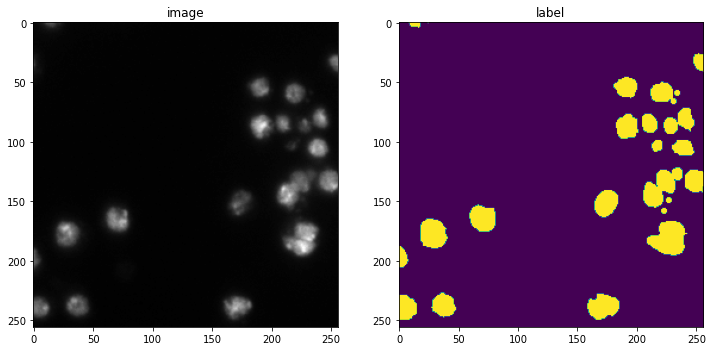

In [43]:
print("Checking Images/Labels as-is (Validation Dataset)")
# Create a dataset using validation files and the specified validation transforms
check_ds = Dataset(data=val_files, transform=val_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader = DataLoader(check_ds, batch_size=1)

# Retrieve the first batch of data from the DataLoader
check_data = first(check_loader)

# Extract the image and label from the data
image, label = (check_data["image"][0][0], check_data["label"][0][0])

# Print the shapes of the image and label
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f"{type(image)}")

# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :])
plt.show()


Checking Images/Labels with Example Transformation during Training (Training Dataset)
image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])
<class 'monai.data.meta_tensor.MetaTensor'>
image shape: torch.Size([128, 128]), label shape: torch.Size([128, 128])
<class 'monai.data.meta_tensor.MetaTensor'>


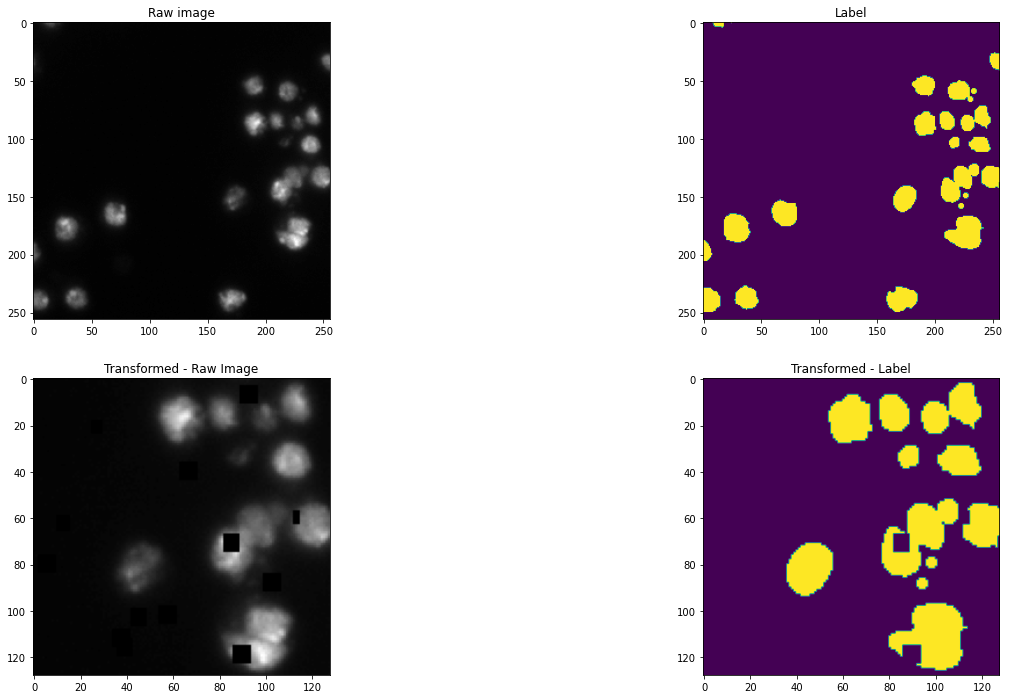

In [44]:
print("Checking Images/Labels with Example Transformation during Training (Training Dataset)")
 # Create a dataset using validation files and the specified validation transforms
check_ds_orig = Dataset(data=val_files, transform=val_transforms)
check_ds_train = Dataset(data=val_files, transform=train_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader_orig = DataLoader(check_ds_orig, batch_size=1)
check_loader_train = DataLoader(check_ds_train, batch_size=1)

# Retrieve the first batch of data from the DataLoader
check_data_orig = first(check_loader_orig)
check_data_train = first(check_loader_train)

# Extract the image and label from the data
image_orig, label_orig = (check_data_orig["image"][0][0], check_data_orig["label"][0][0])
image_train, label_train = (check_data_train["image"][0][0], check_data_train["label"][0][0])


# Print the shapes of the image and label
print(f"image shape: {image_orig.shape}, label shape: {label_orig.shape}")
print(f"{type(image_orig)}")
print(f"image shape: {image_train.shape}, label shape: {label_train.shape}")
print(f"{type(image_train)}")

# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (24, 12))
plt.subplot(2, 2,1)
plt.title("Raw image")
plt.imshow(image_orig[:, :], cmap="gray")
plt.subplot(2, 2, 2)
plt.title("Label")
plt.imshow(label_orig[:, :])
#
plt.figure("check", (12, 6))
plt.subplot(2, 2, 3)
plt.title("Transformed - Raw Image")
plt.imshow(image_train[:, :], cmap="gray")
plt.subplot(2, 2, 4)
plt.title("Transformed - Label")
plt.imshow(label_train[:, :])

plt.subplots_adjust(wspace=0.00000001, hspace=0.2)
plt.show()


Checking Images/Labels with Example Transformation during Training (Training Dataset)
image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])
<class 'monai.data.meta_tensor.MetaTensor'>
image shape: torch.Size([128, 128]), label shape: torch.Size([128, 128])
<class 'monai.data.meta_tensor.MetaTensor'>


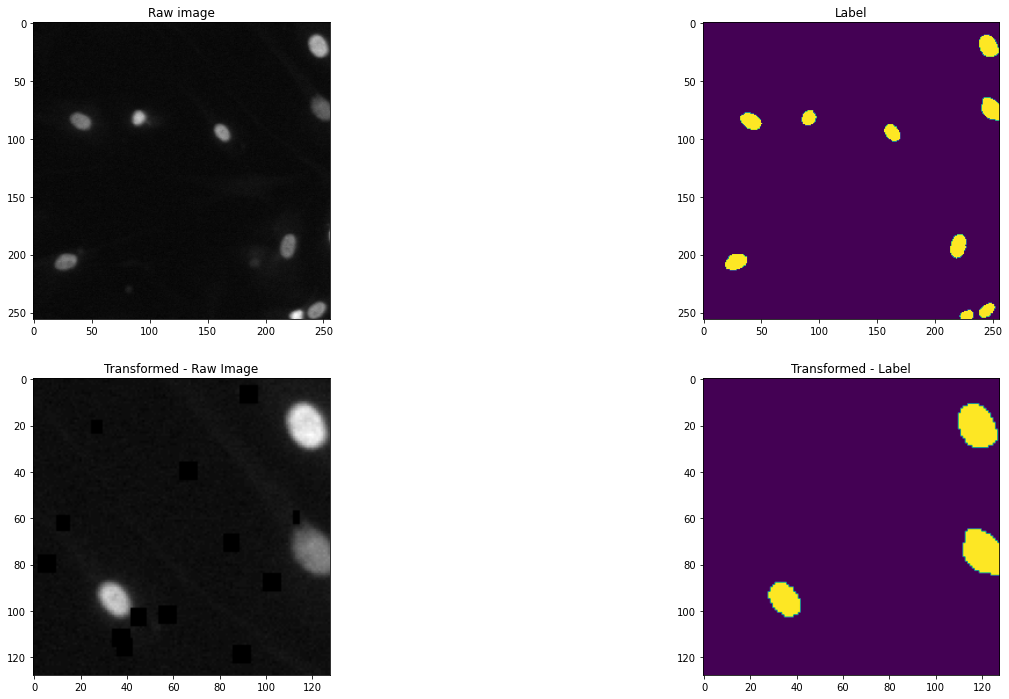

In [45]:
print("Checking Images/Labels with Example Transformation during Training (Training Dataset)")
 # Create a dataset using validation files and the specified validation transforms
check_ds_orig = Dataset(data=train_files, transform=val_transforms)
check_ds_train = Dataset(data=train_files, transform=train_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader_orig = DataLoader(check_ds_orig, batch_size=1)
check_loader_train = DataLoader(check_ds_train, batch_size=1)

# Retrieve the first batch of data from the DataLoader
check_data_orig = first(check_loader_orig)
check_data_train = first(check_loader_train)

# Extract the image and label from the data
image_orig, label_orig = (check_data_orig["image"][0][0], check_data_orig["label"][0][0])
image_train, label_train = (check_data_train["image"][0][0], check_data_train["label"][0][0])


# Print the shapes of the image and label
print(f"image shape: {image_orig.shape}, label shape: {label_orig.shape}")
print(f"{type(image_orig)}")
print(f"image shape: {image_train.shape}, label shape: {label_train.shape}")
print(f"{type(image_train)}")

# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (24, 12))
plt.subplot(2, 2,1)
plt.title("Raw image")
plt.imshow(image_orig[:, :], cmap="gray")
plt.subplot(2, 2, 2)
plt.title("Label")
plt.imshow(label_orig[:, :])
#
plt.figure("check", (12, 6))
plt.subplot(2, 2, 3)
plt.title("Transformed - Raw Image")
plt.imshow(image_train[:, :], cmap="gray")
plt.subplot(2, 2, 4)
plt.title("Transformed - Label")
plt.imshow(label_train[:, :])

plt.subplots_adjust(wspace=0.00000001, hspace=0.2)
plt.show()


## Define CacheDataset and DataLoader for training and validation

In [46]:
# Create a CacheDataset for training with accelerated caching
# CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
#Cache is used to make things faster and load onto RAM. Applies all data augmentation on the compose until the point of a probability function (Random--- based funcions)


# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# train_ds = Dataset(data=train_files, transform=train_transforms)

# Use DataLoader to load training data in batches of size 2
# Shuffle the data for randomization and apply RandCropByPosNegLabeld for data augmentation
# The resulting batch size will be 2 x 4, generating 2 batches of 4 images each for network training
#HYPERPARAMETER batch_size
train_loader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, num_workers=4)
#shuffle is important at the moment of training so that as it learns in a shuffled order evry time
#num of workers for CPU cores

# Create a CacheDataset for validation with accelerated caching
# Similar to training, CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# val_ds = Dataset(data=val_files, transform=val_transforms)

# Use DataLoader to load validation data in batches of size 1, only one as we are not training anymore
# NumWorkers enables multi-threading during data loading for faster processing
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|███████████████████████| 134/134 [00:01<00:00, 118.79it/s]


In [47]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" #for using GPU via CUDA
#optionally IF multiple GPU cores are available, this can be limited to a list of the cores to use via os.environ["CUDA_VISIBLE_DEVICES"]="0" or os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3,4"

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #cuda:0 will use the first available GPU, as default is cuda:0
device = torch.device("cuda:0")
#device = torch.device("cpu")

In [48]:
#Iteration of the whole model over each image to be fed (image being a tensor B*C*H*W*D = 8*1*96*96*96)
for batch_data in train_loader:
    inputs, labels = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )
    print(f"Input image shape: {inputs.shape}") # should be B x C X H X W X D
    print(f"Input label shape: {labels.shape}")
    break



Input image shape: torch.Size([8, 1, 128, 128])
Input label shape: torch.Size([8, 1, 128, 128])


In [49]:
#check if CUDA available - should return True
torch.cuda.is_available()

True

# **Section 3:  Create model**

From here on the cells with ##UNET## are to be used for the UNET model and cells with ##UNETR## are to be used only for the UNETR model

In [20]:
##################
#### UNET ####### 
#################

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), #5 convolution blocks with such kernel sizes each
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=dropout,
).to(device)
print(model)

print(sum(p.numel() for p in model.parameters()))

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.1, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.1, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convol

In [50]:
##################
#### UNETR ####### 
#################

#requires EINOPS to be installed and imported
model_UNETR = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=CropSpatialSize, #needs to be same size as the crop after rand crop
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=dropout,
    spatial_dims=2
).to(device)

#(in_channels, out_channels, img_size,
#feature_size=16, hidden_size=768, mlp_dim=3072, num_heads=12,
#pos_embed='conv',
#proj_type='conv',
#norm_name='instance', conv_block=True, res_block=True, dropout_rate=0.0, spatial_dims=3, qkv_bias=False, save_attn=False)

print(model_UNETR)
#in the model Conv3d [input output] indicated convolution for encoder and ConvTranspose3d indicated deconvolution for decoder
#everything printed is MONAI running Pytorch a certain number of times in order rto have  awhole UNET (in this case)

#important for seeing how many parameters are learnt: The coefficients (or weights) of linear and logistic regression models. Weights and biases of a nn
print(sum(p.numel() for p in model_UNETR.parameters()))


UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
        (1): Linear(in_features=256, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.1, inplace=False)
          (drop2): Dropout(p=0.1, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv 

# **Section 4:  Define loss function, Optimizer, and Evaluation metric**

In [51]:
##################
#### UNET ###### 
################
#loss_function = DiceLoss(to_onehot_y=True, softmax=True) #onehot deafults to False
#learning_rate=learning #HYPERPARAMETER learning_rate
#optimizer = torch.optim.Adam(model.parameters(), learning_rate) #SGD or Adamw can be viable alternative. 1e-4 as learning rate (to be played with, hyperparameter, test 0.01, 0.001, 0.0001 always in 10x scales at each trial)
#dice_metric = DiceMetric(include_background=False, reduction="mean")

#################
#### UNETR ###### 
#################
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #onehot deafults to False
learning_rate=learning #HYPERPARAMETER learning_rate
optimizer = torch.optim.Adam(model_UNETR.parameters(), learning_rate) #SGD or Adamw can be viable alternative. 1e-4 as learning rate (to be played with, hyperparameter, test 0.01, 0.001, 0.0001 always in 10x scales at each trial)
dice_metric = DiceMetric(include_background=False, reduction="mean")#


# **Section 5:  Execute a typical PyTorch training process**

In [22]:
################
#### UNET ###### 
#################
##model

# Define maximum number of epochs and validation interval
max_epochs = MaxEpochs # - HYPERPARAMETER
val_interval = ValInterval #i.e. 2 epoch training every 1 of validation - HYPERPARAMETER

# Initialize variables for tracking best metric and associated epoch
best_metric = -1
best_metric_epoch = -1

# Lists to store epoch loss values and metric values
epoch_loss_values = []
metric_values = []

# Define post-processing transforms for predictions and labels
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)]) #in order to dicretize the percentages the model expresses of certainty, i.e. so 67% confidence corresponds to 1 and 23% to 0)
post_label = Compose([AsDiscrete(to_onehot=2)])

print("Number of epochs: "+str(MaxEpochs))
print("Number of Steps between Epochs (TrainImages/BatchSize): "+str(len(train_ds) // train_loader.batch_size));

# Iterate over epochs
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # Set model to training mode
    model.train()
    epoch_loss = 0
    step = 0

    # Iterate over batches in the training loader
    for batch_data in train_loader:
        step += 1
        # Move inputs and labels to GPU
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = loss_function(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        #Printing loss function at each epoch here
        # Update epoch loss
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    # Calculate average epoch loss
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Perform validation at specified intervals
    if (epoch + 1) % val_interval == 0: #if the number epoch+1 divided by val_interval has a residual (residual from division) of 0 then continue (i.e. 2/2 = 1 with 0 res, 2/3 = 0.6 with res 2), basically ensures that it is run at the specified validation interval of 2,3,4... epochs
        model.eval() #eval the model: so have all the parameters fixed, since it's validation
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                # Define ROI size and sliding window batch size
                #CHECK FOR COMPATIBILITY
                #make sure that roi_size*sw_batch_size (the number of times a sliding window is passed through a full image) is at least as large as the original image so to cover the whole image (if larger than original image it is padded and cropped, but if smaller the validation may not be complete)
                roi_size = (CropSpatialSize,CropSpatialSize)
                sw_batch_size = batchsize #batch size for the sliding window (moving from one ROI to another within each image)
                # Perform sliding window inference
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                #no need of loss fucntion step here, since it's validation
                # Compute dice metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # Reset the status for the next validation round
            dice_metric.reset()

            # Append metric value to list
            metric_values.append(metric)

            # Check if current metric is better than best metric
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                # Save the model with the best metric
                torch.save(model.state_dict(), os.path.join(Hyper_folder, model_name)) #way to save model as weights and biases
                print("saved new best metric model")

            # Print current and best metric values
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


Number of epochs: 10
Number of Steps between Epochs (TrainImages/BatchSize): 268
----------
epoch 1/10
1/268, train_loss: 0.5457
2/268, train_loss: 0.5058
3/268, train_loss: 0.5895
4/268, train_loss: 0.4922
5/268, train_loss: 0.4338
6/268, train_loss: 0.5756
7/268, train_loss: 0.3904
8/268, train_loss: 0.4157
9/268, train_loss: 0.4624
10/268, train_loss: 0.6236
11/268, train_loss: 0.4891
12/268, train_loss: 0.4078
13/268, train_loss: 0.3597
14/268, train_loss: 0.6189
15/268, train_loss: 0.3382
16/268, train_loss: 0.4060
17/268, train_loss: 0.4497
18/268, train_loss: 0.3377
19/268, train_loss: 0.3488
20/268, train_loss: 0.3867
21/268, train_loss: 0.5396
22/268, train_loss: 0.4199
23/268, train_loss: 0.2639
24/268, train_loss: 0.6777
25/268, train_loss: 0.2915
26/268, train_loss: 0.2083
27/268, train_loss: 0.6272
28/268, train_loss: 0.2543
29/268, train_loss: 0.5124
30/268, train_loss: 0.6226
31/268, train_loss: 0.4714
32/268, train_loss: 0.4966
33/268, train_loss: 0.3392
34/268, train_l

26/268, train_loss: 0.4755
27/268, train_loss: 0.4847
28/268, train_loss: 0.2102
29/268, train_loss: 0.3829
30/268, train_loss: 0.5143
31/268, train_loss: 0.3341
32/268, train_loss: 0.4460
33/268, train_loss: 0.3039
34/268, train_loss: 0.4203
35/268, train_loss: 0.4487
36/268, train_loss: 0.1663
37/268, train_loss: 0.0756
38/268, train_loss: 0.3406
39/268, train_loss: 0.3029
40/268, train_loss: 0.4799
41/268, train_loss: 0.1941
42/268, train_loss: 0.3396
43/268, train_loss: 0.1164
44/268, train_loss: 0.2545
45/268, train_loss: 0.1544
46/268, train_loss: 0.2095
47/268, train_loss: 0.1289
48/268, train_loss: 0.4998
49/268, train_loss: 0.3326
50/268, train_loss: 0.1696
51/268, train_loss: 0.1302
52/268, train_loss: 0.1223
53/268, train_loss: 0.4490
54/268, train_loss: 0.3659


/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 65536, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


55/268, train_loss: 0.1729
56/268, train_loss: 0.0815
57/268, train_loss: 0.5348
58/268, train_loss: 0.4439
59/268, train_loss: 0.1647
60/268, train_loss: 0.3852
61/268, train_loss: 0.3426
62/268, train_loss: 0.4529
63/268, train_loss: 0.3603
64/268, train_loss: 0.1931
65/268, train_loss: 0.3160
66/268, train_loss: 0.2041
67/268, train_loss: 0.1215
68/268, train_loss: 0.1411
69/268, train_loss: 0.4430
70/268, train_loss: 0.4118
71/268, train_loss: 0.4095
72/268, train_loss: 0.1013
73/268, train_loss: 0.1945
74/268, train_loss: 0.4914
75/268, train_loss: 0.1106
76/268, train_loss: 0.3502
77/268, train_loss: 0.0637
78/268, train_loss: 0.1869
79/268, train_loss: 0.3808
80/268, train_loss: 0.1256
81/268, train_loss: 0.1271
82/268, train_loss: 0.1304
83/268, train_loss: 0.1258
84/268, train_loss: 0.4622
85/268, train_loss: 0.3247
86/268, train_loss: 0.1458
87/268, train_loss: 0.1765
88/268, train_loss: 0.1373
89/268, train_loss: 0.1852
90/268, train_loss: 0.2337
91/268, train_loss: 0.2446
9

81/268, train_loss: 0.2800
82/268, train_loss: 0.3106
83/268, train_loss: 0.0709
84/268, train_loss: 0.3416
85/268, train_loss: 0.4770
86/268, train_loss: 0.1425
87/268, train_loss: 0.0628
88/268, train_loss: 0.1284
89/268, train_loss: 0.1804
90/268, train_loss: 0.3735
91/268, train_loss: 0.1755
92/268, train_loss: 0.0798
93/268, train_loss: 0.1508
94/268, train_loss: 0.0722
95/268, train_loss: 0.0638
96/268, train_loss: 0.1466
97/268, train_loss: 0.3463
98/268, train_loss: 0.0940
99/268, train_loss: 0.3554
100/268, train_loss: 0.0702
101/268, train_loss: 0.4975
102/268, train_loss: 0.2016
103/268, train_loss: 0.0909
104/268, train_loss: 0.3531
105/268, train_loss: 0.1226
106/268, train_loss: 0.2100
107/268, train_loss: 0.2168
108/268, train_loss: 0.1548
109/268, train_loss: 0.3916
110/268, train_loss: 0.1830
111/268, train_loss: 0.1163
112/268, train_loss: 0.2007
113/268, train_loss: 0.0769
114/268, train_loss: 0.0896
115/268, train_loss: 0.3539
116/268, train_loss: 0.0841
117/268, tr

/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 65536, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


246/268, train_loss: 0.1641
247/268, train_loss: 0.1174
248/268, train_loss: 0.1482
249/268, train_loss: 0.1223
250/268, train_loss: 0.2007
251/268, train_loss: 0.2096
252/268, train_loss: 0.1646
253/268, train_loss: 0.2670
254/268, train_loss: 0.2869
255/268, train_loss: 0.1394
256/268, train_loss: 0.2498
257/268, train_loss: 0.3562
258/268, train_loss: 0.4602
259/268, train_loss: 0.3539
260/268, train_loss: 0.0640
261/268, train_loss: 0.0916
262/268, train_loss: 0.1912
263/268, train_loss: 0.2360
264/268, train_loss: 0.1546
265/268, train_loss: 0.0881
266/268, train_loss: 0.3224
267/268, train_loss: 0.3196
268/268, train_loss: 0.2000
epoch 3 average loss: 0.2229
----------
epoch 4/10
1/268, train_loss: 0.1630
2/268, train_loss: 0.3716
3/268, train_loss: 0.0977
4/268, train_loss: 0.4017
5/268, train_loss: 0.1117
6/268, train_loss: 0.0922
7/268, train_loss: 0.1625
8/268, train_loss: 0.3394
9/268, train_loss: 0.0860
10/268, train_loss: 0.1012
11/268, train_loss: 0.2893
12/268, train_los

1/268, train_loss: 0.1665
2/268, train_loss: 0.1810
3/268, train_loss: 0.2585
4/268, train_loss: 0.1703
5/268, train_loss: 0.2824
6/268, train_loss: 0.1432
7/268, train_loss: 0.1338
8/268, train_loss: 0.0943
9/268, train_loss: 0.2466
10/268, train_loss: 0.0954
11/268, train_loss: 0.1484
12/268, train_loss: 0.1160
13/268, train_loss: 0.1891
14/268, train_loss: 0.1655
15/268, train_loss: 0.1881
16/268, train_loss: 0.1815
17/268, train_loss: 0.2025
18/268, train_loss: 0.1234
19/268, train_loss: 0.1335
20/268, train_loss: 0.2090
21/268, train_loss: 0.3423
22/268, train_loss: 0.0645
23/268, train_loss: 0.1564
24/268, train_loss: 0.1449
25/268, train_loss: 0.1537
26/268, train_loss: 0.0397
27/268, train_loss: 0.2228
28/268, train_loss: 0.3849
29/268, train_loss: 0.2059
30/268, train_loss: 0.2094
31/268, train_loss: 0.0821
32/268, train_loss: 0.2314
33/268, train_loss: 0.0651
34/268, train_loss: 0.2204
35/268, train_loss: 0.1978
36/268, train_loss: 0.1309
37/268, train_loss: 0.2516
38/268, tr

/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 81920, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


84/268, train_loss: 0.2218
85/268, train_loss: 0.2756
86/268, train_loss: 0.1969
87/268, train_loss: 0.1054
88/268, train_loss: 0.1090
89/268, train_loss: 0.0928
90/268, train_loss: 0.2939
91/268, train_loss: 0.0951
92/268, train_loss: 0.1033
93/268, train_loss: 0.1605
94/268, train_loss: 0.1432
95/268, train_loss: 0.4390
96/268, train_loss: 0.2539
97/268, train_loss: 0.0882
98/268, train_loss: 0.1192
99/268, train_loss: 0.1312
100/268, train_loss: 0.2468
101/268, train_loss: 0.1900
102/268, train_loss: 0.0466
103/268, train_loss: 0.4253
104/268, train_loss: 0.1762
105/268, train_loss: 0.0756
106/268, train_loss: 0.4307
107/268, train_loss: 0.2053
108/268, train_loss: 0.4503
109/268, train_loss: 0.1015
110/268, train_loss: 0.2928
111/268, train_loss: 0.0624
112/268, train_loss: 0.2182
113/268, train_loss: 0.2086
114/268, train_loss: 0.1129
115/268, train_loss: 0.0902
116/268, train_loss: 0.0764
117/268, train_loss: 0.3446
118/268, train_loss: 0.1717
119/268, train_loss: 0.1750
120/268,

115/268, train_loss: 0.0950
116/268, train_loss: 0.2657
117/268, train_loss: 0.3718
118/268, train_loss: 0.1548
119/268, train_loss: 0.0856
120/268, train_loss: 0.0845
121/268, train_loss: 0.0629
122/268, train_loss: 0.1128
123/268, train_loss: 0.1845
124/268, train_loss: 0.3416
125/268, train_loss: 0.1219
126/268, train_loss: 0.0563
127/268, train_loss: 0.0494
128/268, train_loss: 0.0982
129/268, train_loss: 0.1292
130/268, train_loss: 0.0669
131/268, train_loss: 0.1781
132/268, train_loss: 0.0659
133/268, train_loss: 0.0670
134/268, train_loss: 0.1914
135/268, train_loss: 0.2605
136/268, train_loss: 0.1831
137/268, train_loss: 0.1606
138/268, train_loss: 0.1708
139/268, train_loss: 0.0981
140/268, train_loss: 0.0940
141/268, train_loss: 0.3945
142/268, train_loss: 0.0621
143/268, train_loss: 0.0659
144/268, train_loss: 0.1534
145/268, train_loss: 0.0997
146/268, train_loss: 0.1167
147/268, train_loss: 0.0433
148/268, train_loss: 0.2954
149/268, train_loss: 0.1339
150/268, train_loss:

/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 65536, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


210/268, train_loss: 0.1514
211/268, train_loss: 0.2609
212/268, train_loss: 0.1038
213/268, train_loss: 0.0490
214/268, train_loss: 0.0705
215/268, train_loss: 0.0945
216/268, train_loss: 0.0831
217/268, train_loss: 0.0367
218/268, train_loss: 0.1898
219/268, train_loss: 0.0825
220/268, train_loss: 0.2822
221/268, train_loss: 0.2083
222/268, train_loss: 0.2716
223/268, train_loss: 0.4376
224/268, train_loss: 0.3376
225/268, train_loss: 0.1852
226/268, train_loss: 0.0442
227/268, train_loss: 0.1182
228/268, train_loss: 0.1620
229/268, train_loss: 0.0826
230/268, train_loss: 0.1326
231/268, train_loss: 0.2587
232/268, train_loss: 0.2023
233/268, train_loss: 0.0752
234/268, train_loss: 0.1213
235/268, train_loss: 0.0500
236/268, train_loss: 0.1371
237/268, train_loss: 0.0821
238/268, train_loss: 0.1352
239/268, train_loss: 0.0883
240/268, train_loss: 0.3898
241/268, train_loss: 0.0783
242/268, train_loss: 0.1618
243/268, train_loss: 0.0890
244/268, train_loss: 0.0867
245/268, train_loss:

/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 65536, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


39/268, train_loss: 0.2147
40/268, train_loss: 0.4260
41/268, train_loss: 0.1403
42/268, train_loss: 0.0993
43/268, train_loss: 0.2091
44/268, train_loss: 0.1452
45/268, train_loss: 0.1640
46/268, train_loss: 0.1640
47/268, train_loss: 0.0650
48/268, train_loss: 0.0496
49/268, train_loss: 0.4303
50/268, train_loss: 0.1509
51/268, train_loss: 0.0694
52/268, train_loss: 0.4097
53/268, train_loss: 0.0964
54/268, train_loss: 0.1987
55/268, train_loss: 0.0609
56/268, train_loss: 0.2191
57/268, train_loss: 0.0991
58/268, train_loss: 0.1525
59/268, train_loss: 0.0662
60/268, train_loss: 0.2263
61/268, train_loss: 0.1602
62/268, train_loss: 0.1418
63/268, train_loss: 0.0468
64/268, train_loss: 0.0355
65/268, train_loss: 0.2370
66/268, train_loss: 0.1858
67/268, train_loss: 0.0865
68/268, train_loss: 0.0651
69/268, train_loss: 0.2946
70/268, train_loss: 0.1159
71/268, train_loss: 0.1140
72/268, train_loss: 0.0489
73/268, train_loss: 0.1551
74/268, train_loss: 0.1107
75/268, train_loss: 0.0846
7

67/268, train_loss: 0.0999
68/268, train_loss: 0.2235
69/268, train_loss: 0.1270
70/268, train_loss: 0.1755
71/268, train_loss: 0.0641
72/268, train_loss: 0.2045
73/268, train_loss: 0.1280
74/268, train_loss: 0.1134
75/268, train_loss: 0.1500
76/268, train_loss: 0.2201
77/268, train_loss: 0.1057
78/268, train_loss: 0.0350
79/268, train_loss: 0.1175
80/268, train_loss: 0.1389
81/268, train_loss: 0.3030
82/268, train_loss: 0.1889
83/268, train_loss: 0.0654
84/268, train_loss: 0.1017
85/268, train_loss: 0.2101
86/268, train_loss: 0.1848
87/268, train_loss: 0.3659
88/268, train_loss: 0.0677
89/268, train_loss: 0.2948
90/268, train_loss: 0.0679
91/268, train_loss: 0.2420
92/268, train_loss: 0.1325
93/268, train_loss: 0.0894
94/268, train_loss: 0.3180
95/268, train_loss: 0.0965
96/268, train_loss: 0.2418
97/268, train_loss: 0.1963
98/268, train_loss: 0.1543
99/268, train_loss: 0.1902
100/268, train_loss: 0.1731
101/268, train_loss: 0.1789
102/268, train_loss: 0.0820
103/268, train_loss: 0.16

/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 81920, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


9/268, train_loss: 0.1199
10/268, train_loss: 0.1227
11/268, train_loss: 0.0940
12/268, train_loss: 0.0473
13/268, train_loss: 0.1583
14/268, train_loss: 0.0518
15/268, train_loss: 0.1363
16/268, train_loss: 0.1335
17/268, train_loss: 0.1568
18/268, train_loss: 0.2920
19/268, train_loss: 0.0465
20/268, train_loss: 0.4050
21/268, train_loss: 0.1485
22/268, train_loss: 0.1387
23/268, train_loss: 0.1629
24/268, train_loss: 0.0501
25/268, train_loss: 0.1038
26/268, train_loss: 0.2032
27/268, train_loss: 0.0700
28/268, train_loss: 0.1565
29/268, train_loss: 0.2463
30/268, train_loss: 0.1309
31/268, train_loss: 0.0994
32/268, train_loss: 0.1451
33/268, train_loss: 0.0589
34/268, train_loss: 0.2191
35/268, train_loss: 0.0991
36/268, train_loss: 0.1639
37/268, train_loss: 0.1285
38/268, train_loss: 0.0945
39/268, train_loss: 0.1406
40/268, train_loss: 0.1088
41/268, train_loss: 0.1294
42/268, train_loss: 0.1271
43/268, train_loss: 0.0772
44/268, train_loss: 0.1058
45/268, train_loss: 0.0909
46

41/268, train_loss: 0.0268
42/268, train_loss: 0.1851
43/268, train_loss: 0.0935
44/268, train_loss: 0.2056
45/268, train_loss: 0.1467
46/268, train_loss: 0.0328
47/268, train_loss: 0.2062
48/268, train_loss: 0.0578
49/268, train_loss: 0.2082
50/268, train_loss: 0.1309
51/268, train_loss: 0.0637
52/268, train_loss: 0.1146
53/268, train_loss: 0.0524
54/268, train_loss: 0.0642
55/268, train_loss: 0.0707
56/268, train_loss: 0.0841
57/268, train_loss: 0.1513
58/268, train_loss: 0.1944
59/268, train_loss: 0.1347
60/268, train_loss: 0.2075
61/268, train_loss: 0.2037
62/268, train_loss: 0.2432
63/268, train_loss: 0.0984
64/268, train_loss: 0.0631
65/268, train_loss: 0.1773
66/268, train_loss: 0.2043
67/268, train_loss: 0.0736
68/268, train_loss: 0.1234
69/268, train_loss: 0.0736
70/268, train_loss: 0.1917
71/268, train_loss: 0.0877
72/268, train_loss: 0.0534
73/268, train_loss: 0.1098
74/268, train_loss: 0.2043
75/268, train_loss: 0.0687
76/268, train_loss: 0.0227
77/268, train_loss: 0.0940
7

In [ ]:
##################
##### UNETR ###### 
##################
##model_UNETR#

# Define maximum number of epochs and validation interval
max_epochs = MaxEpochs # - HYPERPARAMETER
val_interval = ValInterval #i.e. 2 epoch training every 1 of validation - HYPERPARAMETER

# Initialize variables for tracking best metric and associated epoch
best_metric = -1
best_metric_epoch = -1

# Lists to store epoch loss values and metric values
epoch_loss_values = []
metric_values = []

# Define post-processing transforms for predictions and labels
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)]) #in order to dicretize the percentages the model expresses of certainty, i.e. so 67% confidence corresponds to 1 and 23% to 0)
post_label = Compose([AsDiscrete(to_onehot=2)])

print("Number of epochs: "+str(MaxEpochs))
print("Number of Steps between Epochs (TrainImages/BatchSize): "+str(len(train_ds) // train_loader.batch_size));

# Iterate over epochs
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # Set model to training mode
    model_UNETR.train()
    epoch_loss = 0
    step = 0

    # Iterate over batches in the training loader
    for batch_data in train_loader:
        step += 1
        # Move inputs and labels to GPU
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_UNETR(inputs)
        # Compute loss
        loss = loss_function(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        #Printing loss function at each epoch here
        # Update epoch loss
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    # Calculate average epoch loss
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Perform validation at specified intervals
    if (epoch + 1) % val_interval == 0: #if the number epoch+1 divided by val_interval has a residual (residual from division) of 0 then continue (i.e. 2/2 = 1 with 0 res, 2/3 = 0.6 with res 2), basically ensures that it is run at the specified validation interval of 2,3,4... epochs
        model_UNETR.eval() #eval the model: so have all the parameters fixed, since it's validation
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                # Define ROI size and sliding window batch size
                #CHECK FOR COMPATIBILITY
                #make sure that roi_size*sw_batch_size (the number of times a sliding window is passed through a full image) is at least as large as the original image so to cover the whole image (if larger than original image it is padded and cropped, but if smaller the validation may not be complete)
                roi_size = (CropSpatialSize,CropSpatialSize)
                sw_batch_size = batchsize #batch size for the sliding window (moving from one ROI to another within each image)
                # Perform sliding window inference
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model_UNETR)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                #no need of loss fucntion step here, since it's validation
                # Compute dice metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # Reset the status for the next validation round
            dice_metric.reset()

            # Append metric value to list
            metric_values.append(metric)

            # Check if current metric is better than best metric
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                # Save the model with the best metric
                torch.save(model_UNETR.state_dict(), os.path.join(Hyper_folder, model_name)) #way to save model as weights and biases
                print("saved new best metric model")

            # Print current and best metric values
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )#


Number of epochs: 10
Number of Steps between Epochs (TrainImages/BatchSize): 268
----------
epoch 1/10
1/268, train_loss: 0.6746
2/268, train_loss: 0.4972
3/268, train_loss: 0.5401
4/268, train_loss: 0.3941
5/268, train_loss: 0.5801
6/268, train_loss: 0.4109
7/268, train_loss: 0.2546
8/268, train_loss: 0.4328
9/268, train_loss: 0.3832
10/268, train_loss: 0.4226
11/268, train_loss: 0.2452
12/268, train_loss: 0.2245
13/268, train_loss: 0.2217
14/268, train_loss: 0.2667
15/268, train_loss: 0.3386
16/268, train_loss: 0.2519
17/268, train_loss: 0.1711
18/268, train_loss: 0.4795
19/268, train_loss: 0.1538
20/268, train_loss: 0.3541
21/268, train_loss: 0.2578
22/268, train_loss: 0.1045
23/268, train_loss: 0.0690
24/268, train_loss: 0.0922
25/268, train_loss: 0.1124
26/268, train_loss: 0.0553
27/268, train_loss: 0.1042
28/268, train_loss: 0.0666
29/268, train_loss: 0.1401
30/268, train_loss: 0.0808
31/268, train_loss: 0.1983
32/268, train_loss: 0.0929
33/268, train_loss: 0.3227
34/268, train_l

/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 90220, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


1/268, train_loss: 0.0492
2/268, train_loss: 0.3157
3/268, train_loss: 0.0544
4/268, train_loss: 0.3907
5/268, train_loss: 0.0316
6/268, train_loss: 0.1154
7/268, train_loss: 0.0572
8/268, train_loss: 0.2666
9/268, train_loss: 0.1417
10/268, train_loss: 0.0678
11/268, train_loss: 0.1371
12/268, train_loss: 0.0478
13/268, train_loss: 0.1425
14/268, train_loss: 0.1619
15/268, train_loss: 0.0409
16/268, train_loss: 0.1085
17/268, train_loss: 0.1634
18/268, train_loss: 0.1902


/home/alex/anaconda3/lib/python3.9/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 0, Num backgrounds 81920, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


19/268, train_loss: 0.0752
20/268, train_loss: 0.1062
21/268, train_loss: 0.1883
22/268, train_loss: 0.0372
23/268, train_loss: 0.1030
24/268, train_loss: 0.0683
25/268, train_loss: 0.1655
26/268, train_loss: 0.0406
27/268, train_loss: 0.1575
28/268, train_loss: 0.4091
29/268, train_loss: 0.0270
30/268, train_loss: 0.2312
31/268, train_loss: 0.1573
32/268, train_loss: 0.0644
33/268, train_loss: 0.1546
34/268, train_loss: 0.0414
35/268, train_loss: 0.0447
36/268, train_loss: 0.1082
37/268, train_loss: 0.0795
38/268, train_loss: 0.1771
39/268, train_loss: 0.0487
40/268, train_loss: 0.0484
41/268, train_loss: 0.1244
42/268, train_loss: 0.2769
43/268, train_loss: 0.2743
44/268, train_loss: 0.1018
45/268, train_loss: 0.0735
46/268, train_loss: 0.0484
47/268, train_loss: 0.2707
48/268, train_loss: 0.0559
49/268, train_loss: 0.0883
50/268, train_loss: 0.1245
51/268, train_loss: 0.1448
52/268, train_loss: 0.0665
53/268, train_loss: 0.1449
54/268, train_loss: 0.1083
55/268, train_loss: 0.0351
5

43/268, train_loss: 0.1993
44/268, train_loss: 0.1882
45/268, train_loss: 0.2044
46/268, train_loss: 0.0596
47/268, train_loss: 0.0511
48/268, train_loss: 0.0827
49/268, train_loss: 0.1070
50/268, train_loss: 0.1217
51/268, train_loss: 0.0311
52/268, train_loss: 0.0700
53/268, train_loss: 0.1453
54/268, train_loss: 0.0787
55/268, train_loss: 0.0926
56/268, train_loss: 0.0517
57/268, train_loss: 0.0265
58/268, train_loss: 0.1548
59/268, train_loss: 0.0258
60/268, train_loss: 0.0866
61/268, train_loss: 0.1913
62/268, train_loss: 0.3043
63/268, train_loss: 0.0818
64/268, train_loss: 0.3001
65/268, train_loss: 0.2243
66/268, train_loss: 0.1128
67/268, train_loss: 0.0261
68/268, train_loss: 0.2066
69/268, train_loss: 0.0312
70/268, train_loss: 0.0678
71/268, train_loss: 0.0667
72/268, train_loss: 0.0947
73/268, train_loss: 0.1344
74/268, train_loss: 0.1332
75/268, train_loss: 0.2783
76/268, train_loss: 0.1093
77/268, train_loss: 0.0872
78/268, train_loss: 0.0805
79/268, train_loss: 0.0510
8

71/268, train_loss: 0.1269
72/268, train_loss: 0.1017
73/268, train_loss: 0.1031
74/268, train_loss: 0.0270
75/268, train_loss: 0.1850
76/268, train_loss: 0.1660
77/268, train_loss: 0.0817
78/268, train_loss: 0.0278
79/268, train_loss: 0.2688
80/268, train_loss: 0.0369
81/268, train_loss: 0.2115
82/268, train_loss: 0.0705
83/268, train_loss: 0.1036
84/268, train_loss: 0.2376
85/268, train_loss: 0.0326
86/268, train_loss: 0.0742
87/268, train_loss: 0.0803
88/268, train_loss: 0.3456
89/268, train_loss: 0.1644
90/268, train_loss: 0.2192
91/268, train_loss: 0.3182
92/268, train_loss: 0.1901
93/268, train_loss: 0.0530
94/268, train_loss: 0.0969
95/268, train_loss: 0.1044
96/268, train_loss: 0.0201
97/268, train_loss: 0.0405
98/268, train_loss: 0.1860
99/268, train_loss: 0.0523
100/268, train_loss: 0.0544
101/268, train_loss: 0.1544
102/268, train_loss: 0.2884
103/268, train_loss: 0.0491
104/268, train_loss: 0.1130
105/268, train_loss: 0.1774
106/268, train_loss: 0.1302
107/268, train_loss: 

95/268, train_loss: 0.1695
96/268, train_loss: 0.1890
97/268, train_loss: 0.1583
98/268, train_loss: 0.1738
99/268, train_loss: 0.0663
100/268, train_loss: 0.0330
101/268, train_loss: 0.1399
102/268, train_loss: 0.0774
103/268, train_loss: 0.0464
104/268, train_loss: 0.0663
105/268, train_loss: 0.1510
106/268, train_loss: 0.1901
107/268, train_loss: 0.0817
108/268, train_loss: 0.4008
109/268, train_loss: 0.0256
110/268, train_loss: 0.2024
111/268, train_loss: 0.0469
112/268, train_loss: 0.0516
113/268, train_loss: 0.0623
114/268, train_loss: 0.0847
115/268, train_loss: 0.3869
116/268, train_loss: 0.0333
117/268, train_loss: 0.1195
118/268, train_loss: 0.0810
119/268, train_loss: 0.0356
120/268, train_loss: 0.0516
121/268, train_loss: 0.1040
122/268, train_loss: 0.0432
123/268, train_loss: 0.0846
124/268, train_loss: 0.1208
125/268, train_loss: 0.1682
126/268, train_loss: 0.2768
127/268, train_loss: 0.1266
128/268, train_loss: 0.0970
129/268, train_loss: 0.0538
130/268, train_loss: 0.06

122/268, train_loss: 0.0387
123/268, train_loss: 0.1063
124/268, train_loss: 0.0496
125/268, train_loss: 0.1303
126/268, train_loss: 0.0463
127/268, train_loss: 0.1056
128/268, train_loss: 0.0445
129/268, train_loss: 0.0219
130/268, train_loss: 0.1400
131/268, train_loss: 0.1213
132/268, train_loss: 0.0191
133/268, train_loss: 0.0773
134/268, train_loss: 0.0441
135/268, train_loss: 0.0783
136/268, train_loss: 0.0654
137/268, train_loss: 0.0533
138/268, train_loss: 0.0473
139/268, train_loss: 0.0331
140/268, train_loss: 0.0891
141/268, train_loss: 0.0321
142/268, train_loss: 0.1035
143/268, train_loss: 0.0506
144/268, train_loss: 0.1174
145/268, train_loss: 0.1133
146/268, train_loss: 0.1166
147/268, train_loss: 0.1077
148/268, train_loss: 0.0956
149/268, train_loss: 0.1142
150/268, train_loss: 0.0461
151/268, train_loss: 0.1701
152/268, train_loss: 0.3358
153/268, train_loss: 0.0539
154/268, train_loss: 0.2310
155/268, train_loss: 0.0523
156/268, train_loss: 0.0228
157/268, train_loss:

In [ ]:
#TESTING
#print(epoch_loss_values)
#print(metric_values)
#print(inputs.shape)
#print(outputs.shape)
#print(labels.shape)
#print(inputs)
#print(outputs)
#print(labels)
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
#TESTING


# **Section 6:  Understanding Training Curves**


In [ ]:
#TEMP (this code run only)
#ONLY FOR the model just trained

# Define plot parameters
plt.figure(figsize=(14, 6))

# Plot Epoch Average Loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
x_loss = [i + 1 for i in range(len(epoch_loss_values))]
y_loss = epoch_loss_values
plt.plot(x_loss, y_loss, color='blue', label='Training Loss')
plt.legend()

# Plot Validation Mean Dice
plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
plt.xlabel("Epoch")
plt.ylabel("Mean Dice")
x_dice = [val_interval * (i + 1) for i in range(len(metric_values))]
y_dice = metric_values
plt.plot(x_dice, y_dice, color='green', label='Validation Dice')
plt.legend()

plt.tight_layout()
plt.show()

#however in this case the validation Mean Dice did not go up over time. With more epochs (as shown on MONAI example) it will increase

# **Section 7:  Deploy the best saved model**

In [ ]:
###################################
###### TEMP #######################
######(this code run only)#########
##ONLY FOR the model just trained##
###################################
model.load_state_dict(torch.load(os.path.join(Hyper_folder, model_name)))

#####################################################
###### Load Best Model prev SAVED ################### 
###### UNET or UNETR ################################
#####################################################
#model.load_state_dict(torch.load("/home/alex/Desktop/AI/Figures/Plots/UNET/Res_12/12_UNET_model.pth"))
#model_UNETR.load_state_dict(torch.load("/home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results_UNETR/Res_11/11_UNET_model.pth"))


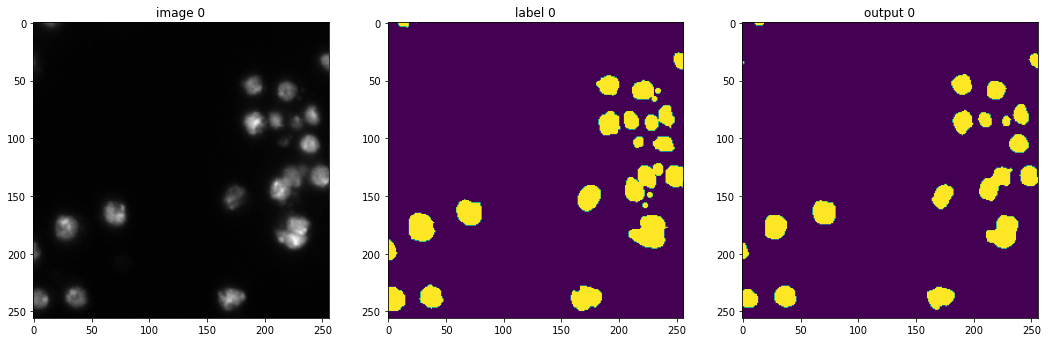

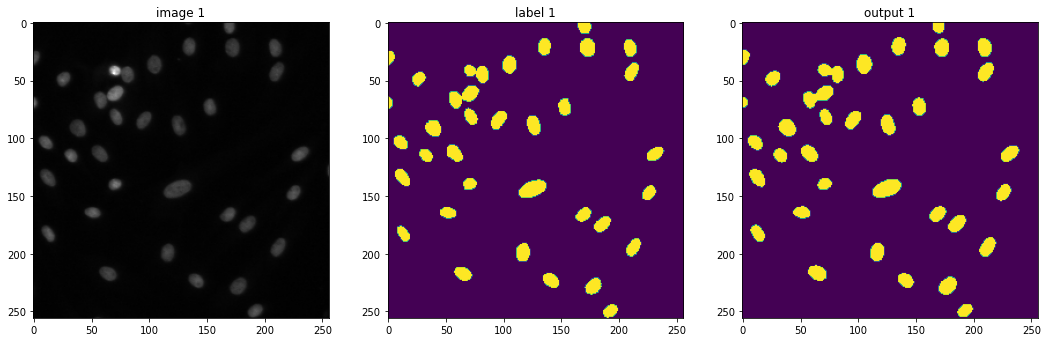

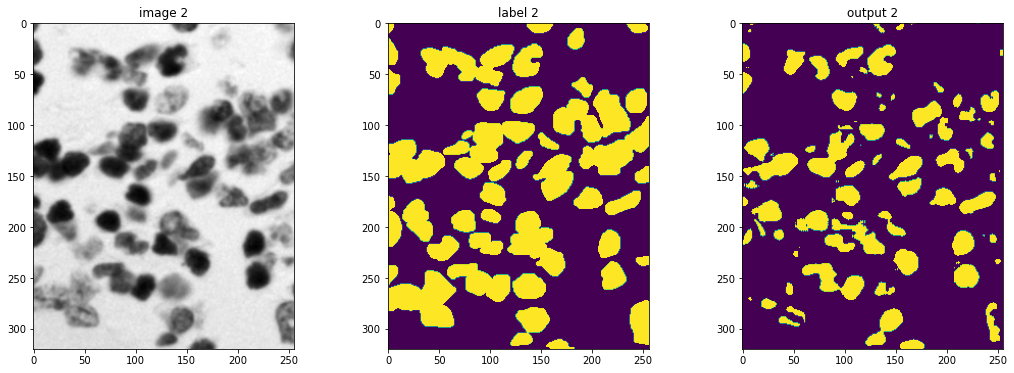

In [27]:
##################
#### UNET ####### 
#################

# Set the model to evaluation mode
model.eval()

# Perform inference on validation data using the best model
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (CropSpatialSize,CropSpatialSize)
        sw_batch_size = batchsize
        val_outputs = sliding_window_inference(val_data["image"].to(device),
                                               roi_size, sw_batch_size, model)

        # Plot the slices
        plt.figure("check", (18, 6))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")

        # Plot ground truth label
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :])

        # Plot model output
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :])
        plt.show()

        # Break loop after 3 iterations for visualization
        if i == 2:
            break

In [ ]:
#################
#### UNETR ###### 
#################

# Set the model to evaluation mode
model_UNETR.eval()

# Perform inference on validation data using the best model
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (CropSpatialSize,CropSpatialSize)
        sw_batch_size = batchsize
        val_outputs = sliding_window_inference(val_data["image"].to(device),
                                               roi_size, sw_batch_size, model_UNETR)

        # Plot the slices
        plt.figure("check", (18, 6))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")

        # Plot ground truth label
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :])

        # Plot model output
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :])
        plt.show()

        # Break loop after 3 iterations for visualization
        if i == 2:
            break
        

# **Section 8:  Model Performance on Test Test**

In [ ]:
#TESTING SET

Test_Images = sorted(glob.glob(os.path.join(Test_directory, "*/RAW_images_8bit/", "*.png")))
Test_Labels = sorted(glob.glob(os.path.join(Test_directory, "*/MIP/", "MIP_masks.png")))
#Test_Labels = sorted(glob.glob(os.path.join(Test_directory, "*/MIP/", "MIP_masks.png")))
data_dicts_Test = [{"image": image_name, "label": label_name} for image_name, label_name in zip(Test_Images, Test_Labels)]
n_Testimage=len(Test_Images)
n_Testlabels=len(Test_Labels)
print("N Test Images available: " + str(n_Testimage))
print("N Test Labels available: " + str(n_Testlabels))
Test_files = data_dicts_Test[0:]
# Create a CacheDataset + DataLoader for Test Set
test_ds = CacheDataset(data=Test_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

In [ ]:
##CHECK GPU again
torch.cuda.is_available()

In [ ]:
print("Checking Images/Labels with Example Transformation during Testing (Testing Dataset)")
 # Create a dataset using validation files and the specified validation transforms
check_ds_orig = Dataset(data=Test_files, transform=val_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader_orig = DataLoader(check_ds_orig, batch_size=1, shuffle=True) #Shuffle=True so that not just the first image is seen

# Retrieve the first batch of data from the DataLoader
check_data_orig = first(check_loader_orig)

# Extract the image and label from the data
image_orig, label_orig = (check_data_orig["image"][0][0], check_data_orig["label"][0][0])

# Print the shapes of the image and label
print(f"image shape: {image_orig.shape}, label shape: {label_orig.shape}")
print(f"{type(image_orig)}")

# Plot a slice of the images and labels (slice along the third dimension at index 80)
plt.figure("check", (12, 6))
plt.subplot(2, 2,1)
plt.title("image")
plt.imshow(image_orig[:, :], cmap="gray")
plt.subplot(2, 2, 2)
plt.title("label")
plt.imshow(label_orig[:, :])


In [31]:
#EVALUATE MODEL on TEST set
#Save model-predicted images
#Output mean Metric (i.e. DSC) and STD across all Test set images

###################################
###### TEMP #######################
######(this code run only)#########
###### or UNET ####################
###### "model" variable ###########
###################################

test_data = Test_files[0:]

# Define original test transforms
test_org_transforms = val_transforms

# Create original test dataset
test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

# Create data loader for original test dataset
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

       
# Load the best saved model parameters
model.eval()

#initialize Counter for For-Loop
count=0

#Initialize List of Lists (both for Pred and Labels)
Pred_list = []
Test_list = [] #old labels from test folder
metric_list=[]
name_list=[]

# Evaluate model performance on test set
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs, test_labels = (
                    test_data["image"].to(device),
                    test_data["label"].to(device),
                )
        roi_size = (CropSpatialSize,CropSpatialSize)
        sw_batch_size = batchsize
        # Perform sliding window inference
        filename=basename(dirname(dirname(Test_files[count]['image'])))
        #print(filename)
        #print(count)
        # Define POST-PROCESSING Transforms (inside the for-loop to keep filenames)
        post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2),  #in order to dicretize the percentages the model expresses of certainty, i.e. so 67% confidence corresponds to 1 and 23% to 0)
                                                                    #to_onehot=2 is used since 2 channels are outputted (foreground and background)
                             SaveImage(output_dir=Hyper_folder,output_ext='.png',output_postfix=filename,
                                       #scale='uint8',
                                       #output_dtype='np.uint8'
                              )]) #Save Predicted Images
        #post_label = Compose([AsDiscrete(argmax=True, to_onehot=2),
                             #SaveImage(output_dir=Hyper_folder,output_ext='.png',output_postfix=filename,
                                       #scale='uint8',
                                       #output_dtype='np.uint8'
                              #)
                            # ])
        #Sliding Inference
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model) #UNET vs UNETR
        #Apply Transforms and Save Predictions/Labels
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        #test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        #plt.figure
        # Compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)
        metric_temp=dice_metric.aggregate().item()
        
        #List of all DICE scores per image
        name_list.append(filename)
        metric_list.append(metric_temp)
        #Count
        count=count+1


    # Aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()  
    # Reset the status for the next validation round
    dice_metric.reset()

# Print the metric on the test set
#NOT USED since IoU (as in the competition) is used
print("MeanDice Metric on Test Set: ", metric_org) # as we used validation data now should be the same as best score
print(np.mean(metric_list))
print(np.std(metric_list))

2024-03-19 10:13:12,203 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png
2024-03-19 10:13:12,339 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png
2024-03-19 10:13:12,418 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png
2024-03-19 10:13:12,482 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925.png
2024-03-19 10:13:12,538 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/ima

2024-03-19 10:13:15,993 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04.png
2024-03-19 10:13:16,051 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af.png
2024-03-19 10:13:16,211 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b.png
2024-03-19 10:13:16,404 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/images/images_8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab.png
2024-03-19 10:13:16,469 INFO image_writer.py:197 - writing: /home/alex/Desktop/AI/PreProc_Nuclei_t536v134t65_t73v18t9t/Results/Res_1/ima

In [ ]:
#EVALUATE MODEL on TEST set
#Save model-predicted images
#Output mean Metric (i.e. DSC) and STD across all Test set images

############################
###### UNETR ###############
#############################

test_data = Test_files[0:]

# Define original test transforms
test_org_transforms = val_transforms

# Create original test dataset
test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

# Create data loader for original test dataset
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

       
# Load the best saved model parameters
model_UNETR.eval()

#initialize Counter for For-Loop
count=0

#Initialize List of Lists (both for Pred and Labels)
Pred_list = []
Test_list = [] #old labels from test folder
metric_list=[]
name_list=[]

# Evaluate model performance on test set
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs, test_labels = (
                    test_data["image"].to(device),
                    test_data["label"].to(device),
                )
        roi_size = (CropSpatialSize,CropSpatialSize)
        sw_batch_size = batchsize
        # Perform sliding window inference
        filename=basename(dirname(dirname(Test_files[count]['image'])))
        #print(filename)
        #print(count)
        # Define POST-PROCESSING Transforms (inside the for-loop to keep filenames)
        post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2),  #in order to dicretize the percentages the model expresses of certainty, i.e. so 67% confidence corresponds to 1 and 23% to 0)
                                                                    #to_onehot=2 is used since 2 channels are outputted (foreground and background)
                             SaveImage(output_dir=Hyper_folder,output_ext='.png',output_postfix=filename,
                                       #scale='uint8',
                                       #output_dtype='np.uint8'
                              )]) #Save Predicted Images
        #post_label = Compose([AsDiscrete(argmax=True, to_onehot=2),
                             #SaveImage(output_dir=Hyper_folder,output_ext='.png',output_postfix=filename,
                                       #scale='uint8',
                                       #output_dtype='np.uint8'
                              #)
                            # ])
        #Sliding Inference
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model_UNETR) #UNET vs UNETR
        #Apply Transforms and Save Predictions/Labels
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        #test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        #plt.figure
        # Compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)
        metric_temp=dice_metric.aggregate().item()
         
        #List of all DICE scores per image
        name_list.append(filename)
        metric_list.append(metric_temp)
        #Count
        count=count+1


    # Aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()  #removed as it seems to cause errors
    # Reset the status for the next validation round
    dice_metric.reset()

# Print the metric on the test set
#NOT USED since IoU (as in the competition) is used
print("MeanDice Metric on Test Set: ", metric_org) # as we used validation data now should be the same as best score
print(np.mean(metric_list))
print(np.std(metric_list))

#  **IoU Metric**

In [ ]:
#ORIGINAL

#from https://www.kaggle.com/code/jeremytjordan/exploration-of-u-net-architectures#Evaluation
def iou_at_thresholds(target_mask, pred_mask, thresholds=np.arange(0.5,1,0.05)):
    '''Returns True if IoU is greater than the thresholds.'''
    intersection = np.logical_and(target_mask, pred_mask)
    union = np.logical_or(target_mask, pred_mask)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou > thresholds

def calculate_iou_tensor(target_masks, pred_masks, thresholds=np.arange(0.5,1,0.05)):
    iou_tensor = np.zeros([len(thresholds), len(pred_masks), len(target_masks)])

    # TODO: Use tiling to make this faster
    for i, p_mask in enumerate(pred_masks):
        for j, t_mask in enumerate(target_masks):
            iou_tensor[:, i, j] = iou_at_thresholds(t_mask, p_mask, thresholds)

    return iou_tensor

def calculate_average_precision(target_masks, pred_masks, thresholds=np.arange(0.5,1,0.05)):
    '''Calculates the average precision over a range of thresholds for one observation (with a single class).'''
    iou_tensor = calculate_iou_tensor(target_masks, pred_masks, thresholds=thresholds)
    
    TP = np.sum((np.sum(iou_tensor, axis=2) == 1), axis=1)
    FP = np.sum((np.sum(iou_tensor, axis=1) == 0), axis=1)
    FN = np.sum((np.sum(iou_tensor, axis=2) == 0), axis=1)

    precision = TP / (TP + FP + FN)

    return np.mean(precision)

def calculate_mean_average_precision(y_true, y_pred):
    '''
    # Arguments
        y_true: A list of lists each containing the target masks for a given observation (as an array).
        y_pred: A list of lists each containing the predicted masks for a given observation (as an array).
    '''
    average_precision = []
    thresholds=np.arange(0.5,1,0.05)
    
    for target, prediction in zip(y_true, y_pred):
        ap = calculate_average_precision(target, prediction, thresholds=thresholds)
        average_precision.append(ap)
                
    return average_precision

In [ ]:
###################################################
###### Based on Folders and Lists Loaded ##########
###### or TEMP code run ###########################
###################################################

### Files and Path Legend:
# PREDICTED IMAGES
# os.path.join(Hyper_folder, "images", "images_"+OBS+".png" --> to be made greyscale 8bit binary via cv2
# LABEL IMAGES - preprocess in FIJI 
# os.path.join(Test_directory, OBS+"/MIP/", "MIP_masks.png") --> already gresycale 8bit binary via FIJI

#LISTS OF LISTS for IoU
PRED_list=[]
Y_VAL_masks=[]
#new folder PREDICTED MASKS PREPROCESSED

PredMask_preproc=os.path.join(Hyper_folder, "PredMask_preproc")
if not os.path.exists(PredMask_preproc):
        os.mkdir(PredMask_preproc)

#Predicted Masks Preprocesssing via OpenCV
for OBS in os.listdir(Test_directory):
    #PRED
    #LOAD IMAGE AND RESAVE only for PRED then make collection
    im1 = cv2.imread(os.path.join(Hyper_folder, "images", "images_"+OBS+".png"),cv2.IMREAD_GRAYSCALE)
    im1 = cv2.bitwise_not(im1)
    ret1,im1 = cv2.threshold(im1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    file_out=os.path.join(PredMask_preproc, "images_"+OBS+".png")
    cv2.imwrite(file_out, im1)
    PRED=io.imread_collection(file_out)
    #LABEL - no further processing needed
    LABEL=io.imread_collection(sorted(glob.glob(os.path.join(Test_directory, OBS+"/MIP/", "MIP_masks.png"))))
    PRED_list.append(PRED)
    Y_VAL_masks.append(LABEL)
    
    
avg_prec  = calculate_mean_average_precision(PRED_list, Y_VAL_masks)
sns.displot(avg_prec)
print(f'Mean average precision: {np.mean(avg_prec)} +/- {np.std(avg_prec)}')

In [35]:
###
#SAVE METRICS and named for CLASSES
print(avg_prec)
np.savetxt("/home/alex/Desktop/AI/Figures/Classes/IoU_metric_list_UNETR.csv",
        avg_prec,
        delimiter =", ",
        fmt ='% s')#

name_list_prec=[]
for OBS in os.listdir(Test_directory):
#    print(OBS)
    name_list_prec.append(OBS)

#print(name_list_prec)
np.savetxt("/home/alex/Desktop/AI/Figures/Classes/IoU_name_list_UNETR.csv",
        name_list_prec,
        delimiter =", ",
        fmt ='% s')

[0.0, 0.8, 0.8, 0.0, 0.4, 0.4, 0.7, 0.8, 0.8, 0.4, 0.6, 0.0, 0.8, 0.0, 0.7, 0.0, 0.0, 0.3, 0.0, 0.0, 0.8, 0.7, 0.2, 0.8, 0.4, 0.7, 0.3, 0.3, 0.0, 0.0, 0.0, 0.3, 0.0, 0.3, 0.5, 0.6, 0.6, 0.1, 0.0, 0.3, 0.5, 0.6, 0.6, 0.0, 0.2, 0.4, 0.8, 0.1, 0.7, 0.4, 0.1, 0.0, 0.8, 0.6, 0.8, 0.2, 0.0, 0.7, 0.7, 0.7, 0.8, 0.1, 0.6, 0.7, 0.7]


#  **RLE to PNG conversion**

Used for Converting the Stage-1 Test Labels csv to images (from kaggle)

In [1]:
#CODE used for PREPROCESSING IMAGES in TEST Folder as downloaded from Kaggle
import pandas as pd
import matplotlib.image
import numpy as np 
import os
from PIL import Image as im 
import glob

dir="/home/alex/Desktop/AI/data-science-bowl-2018/TESTS_stage1/stage1_solution.csv"

df = pd.read_csv(dir)
display(df)

def rleToMask(rleString,height,width):
  rows,cols = height,width
  rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
  rlePairs = np.array(rleNumbers).reshape(-1,2)
  img = np.zeros(rows*cols,dtype=np.uint8)
  for index,length in rlePairs:
    index -= 1
    img[index:index+length] = 255
  img = img.reshape(cols,rows)
  img = img.T
  return img

#Directory for Storing Models
directory = "Test_stage1_solution/"
parent_dir="/home/alex/Desktop/AI/Orig_Distribution_t536v134t65_t73v18t9t/Test_65/"
# Path
root_dir = os.path.join(parent_dir, directory)

for ind in df.index:
    #print(df['ImageId'][ind], df['EncodedPixels'][ind])
    img=rleToMask(df["EncodedPixels"][ind],df["Height"][ind],df["Width"][ind])
    #PRINT img or SHOW it
    #print(img)
    #plt.imshow(img[:, :], cmap="gray")
    new_dir=os.path.join(root_dir, str(df['ImageId'][ind]))
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    filename="test_image"+str(ind)+".png"
    new_file=os.path.join(new_dir,filename)
    # saving the final output as a PNG file   
    data = im.fromarray(img) 
    data.save(new_file) 
    
    #OLD#matplotlib.image.imsave(new_file, img) #save image

#IMAGES are to be Binarized and Processed into 8bit via FIJI

,ImageId,EncodedPixels,Height,Width,Usage
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31632 6 31886 10 32139 14 32394 15 32649 17 32...,256,256,Public
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50280 7 50534 10 50788 13 51043 14 51298 16 51...,256,256,Public
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10892 5 11146 9 11401 10 11656 11 11911 13 121...,256,256,Public
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 8 45359 10 45614 12 45869 14 46124 15 46...,256,256,Public
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,38564 4 38819 6 39074 8 39327 11 39582 12 3983...,256,256,Public
...,...,...,...,...,...
4147,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,53498 4 53753 5 53759 1 54009 8 54265 8 54520 ...,256,256,Public
4148,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,56869 4 57124 7 57379 9 57634 11 57890 12 5814...,256,256,Public
4149,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20376 1 20630 4 20884 7 20893 1 21140 12 21395...,256,256,Public
4150,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15891 3 16142 11 16398 12 16653 14 16908 15 17...,256,256,Public
